In [1]:
import os
import sys
sys.path.append('./DreamDiffusion/code/')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from timm.models.vision_transformer import Block

import sc_mbm.utils as ut

c:\Users\kshch\Projects\Наука\Разработка\EEGtoImageDecoder\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset

class TUABDataset(Dataset):
    def __init__(self, path, normal='/normal/01_tcp_ar', abnormal='/abnormal/01_tcp_ar'):
        self.normal_path = path + normal
        self.abnormal_path = path + abnormal
        self.file_paths = []
        self.labels = []

        for file_name in os.listdir(self.normal_path):
            file_path = self.normal_path + "/" + file_name
            self.file_paths.append(file_path)
            self.labels.append(0)

        for file_name in os.listdir(self.abnormal_path):
            file_path = self.abnormal_path + "/" + file_name
            self.file_paths.append(file_path)
            self.labels.append(1)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self.file_paths) + idx
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        return (np.load(file_path, allow_pickle=True), label)

In [ ]:
batch_size = 2
n_chans = 23
patch_size = 11
len = n_chans * patch_size

input = torch.randn(batch_size, n_chans, len)
mae = MAEforEEG(time_len=len, in_chans=n_chans, patch_size=patch_size)

In [4]:
path = r"./datasets/tuab_resampled/tuh_eeg_abnormal/v3.0.1/edf/train"
dataset = EEGDataset(path)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# mae = MAEforEEG(time_len=250, in_chans=23, patch_size=1).to(device)
mae = MAEforEEG(time_len=250, in_chans=23, patch_size=1)
optimizer = torch.optim.AdamW(mae.parameters(), lr=0.001, weight_decay=0.01)

# scheduler = ExponentialLR(optimizer, gamma=0.9)

# early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)
# accelerator = Accelerator()
# clf, optimizer, train_dl, scheduler = accelerator.prepare(clf, optimizer, train_dl, scheduler)

In [6]:
train_loss_history = []
# val_loss_history = []
train_f1_score_history = []
# val_f1_score_history = []

for epoch in range(10):
    print(f'******************* Epoch-{epoch + 1} **********************')
    
    print('\nTraining...')
    mae.train()
    train_loss = 0
    train_f1_macro = 0
    for train_i, (eeg, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        
        loss, pred, mask = mae(eeg.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print("Loss:", float(loss))
        train_loss += loss.item()
    # scheduler.step()
    
    # print('\nValidation...')
    # mae.eval()
    # val_loss = 0
    # val_f1_macro = 0
    # for val_i, (embs, labels) in enumerate(val_dl):
    #     embs = embs.to(device)
    #     labels = labels.to(device)
    #     probs = clf(embs)
        
    #     loss = cross_entropy_loss(probs, labels).cpu()
    #     f1_macro = multiclass_f1_score(probs.argmax(axis=1), labels, num_classes=NUM_CLASSES, average='macro').cpu()

    #     val_loss += loss.item()
    #     val_f1_macro += f1_macro.item()
        
    train_loss /= (train_i + 1)
    # val_loss /=  (val_i + 1)
    train_f1_macro /= (train_i + 1)
    # val_f1_macro /=  (val_i + 1)

    train_loss_history.append(train_loss)
    # val_loss_history.append(val_loss)
    train_f1_score_history.append(train_f1_macro)
    # val_f1_score_history.append(val_f1_macro)

    # early_stopping(val_loss, clf)
    
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
    
    print()
    print('Train loss:', round(train_loss, 5), 'F1-macro:', round(train_f1_macro, 5))
    # print('Val loss:', round(val_loss, 5), 'F1-macro:', round(val_f1_macro, 5))
    print()

******************* Epoch-1 **********************

Training...
Loss: 135434.78125
Loss: 1554465.25
Loss: 1340726.0
Loss: 111975.078125
Loss: 8048.84326171875
Loss: 15084.30078125
Loss: 32491.5859375
Loss: 37578.81640625
Loss: 31150.09375
Loss: 19911.466796875
Loss: 9841.603515625
Loss: 4077.91015625
Loss: 3037.40185546875
Loss: 5260.36767578125
Loss: 8533.7978515625
Loss: 10946.0185546875
Loss: 11558.537109375
Loss: 10414.6318359375
Loss: 8161.474609375
Loss: 5574.76513671875
Loss: 3271.921142578125
Loss: 1684.2772216796875
Loss: 1052.458984375
Loss: 1354.974609375
Loss: 2282.679443359375
Loss: 3316.88037109375
Loss: 3926.804931640625
Loss: 3835.4228515625
Loss: 3128.36181640625
Loss: 2132.03466796875
Loss: 1211.50146484375
Loss: 612.6265869140625
Loss: 402.7013854980469
Loss: 508.9228820800781
Loss: 792.9668579101562
Loss: 1105.2607421875
Loss: 1308.8507080078125
Loss: 1327.697265625
Loss: 1156.689453125
Loss: 857.359375
Loss: 533.4472045898438
Loss: 278.2306823730469
Loss: 147.44737

KeyboardInterrupt: 

In [44]:
mae.to('cpu')

for train_i, (eeg, labels) in enumerate(dataloader):
    loss, pred, mask = mae(eeg.float())
    break
pred = pred.transpose(1, 2)

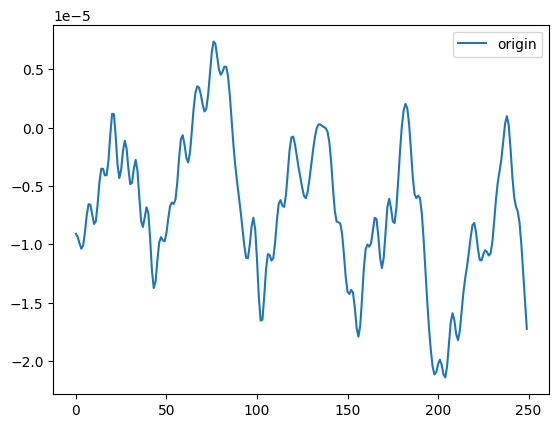

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eeg[0][1].cpu(), label='origin')
plt.legend()

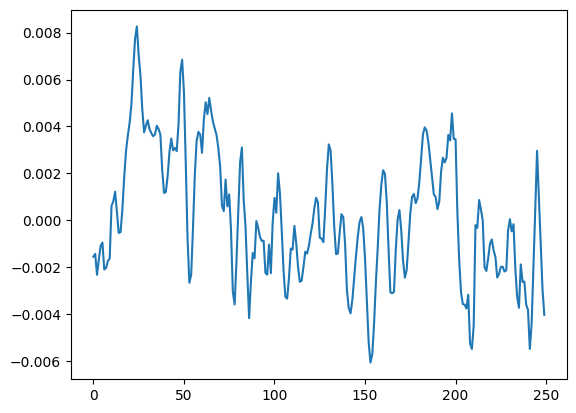

In [50]:
plt.plot(pred[0][1].cpu().detach().numpy(), label='recon')

In [51]:
mae.to(device)
optimizer = torch.optim.AdamW(mae.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
train_loss_history = []
# val_loss_history = []
train_f1_score_history = []
# val_f1_score_history = []

for epoch in range(10):
    print(f'******************* Epoch-{epoch + 1} **********************')
    
    print('\nTraining...')
    mae.train()
    train_loss = 0
    train_f1_macro = 0
    for train_i, (eeg, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        
        eeg = eeg.to(device)
        loss, pred, mask = mae(eeg.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print("Loss:", float(loss))
        train_loss += loss.item()
    # scheduler.step()
    
    # print('\nValidation...')
    # mae.eval()
    # val_loss = 0
    # val_f1_macro = 0
    # for val_i, (embs, labels) in enumerate(val_dl):
    #     embs = embs.to(device)
    #     labels = labels.to(device)
    #     probs = clf(embs)
        
    #     loss = cross_entropy_loss(probs, labels).cpu()
    #     f1_macro = multiclass_f1_score(probs.argmax(axis=1), labels, num_classes=NUM_CLASSES, average='macro').cpu()

    #     val_loss += loss.item()
    #     val_f1_macro += f1_macro.item()
        
    train_loss /= (train_i + 1)
    # val_loss /=  (val_i + 1)
    train_f1_macro /= (train_i + 1)
    # val_f1_macro /=  (val_i + 1)

    train_loss_history.append(train_loss)
    # val_loss_history.append(val_loss)
    train_f1_score_history.append(train_f1_macro)
    # val_f1_score_history.append(val_f1_macro)

    # early_stopping(val_loss, clf)
    
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
    
    print()
    print('Train loss:', round(train_loss, 5), 'F1-macro:', round(train_f1_macro, 5))
    # print('Val loss:', round(val_loss, 5), 'F1-macro:', round(val_f1_macro, 5))
    print()

******************* Epoch-1 **********************

Training...
Loss: 0.5745849013328552
Loss: 112564.2578125
Loss: 8053.9287109375
Loss: 22551.845703125
Loss: 52632.62109375
Loss: 39675.828125
Loss: 13893.1318359375
Loss: 1135.60400390625
Loss: 6154.73291015625
Loss: 16542.169921875
Loss: 19443.90625
Loss: 13923.63671875
Loss: 5887.57568359375
Loss: 916.1663818359375
Loss: 1006.9080200195312
Loss: 4343.6142578125
Loss: 7332.10302734375
Loss: 7629.537109375
Loss: 5375.23974609375
Loss: 2337.7451171875
Loss: 375.5711364746094
Loss: 288.58563232421875
Loss: 1577.9381103515625
Loss: 2979.928955078125
Loss: 3438.414306640625
Loss: 2731.609619140625
Loss: 1419.418212890625
Loss: 331.4386901855469
Loss: 19.127063751220703
Loss: 458.0986633300781
Loss: 1151.244384765625
Loss: 1538.520263671875
Loss: 1379.4310302734375
Loss: 841.4238891601562
Loss: 295.24072265625
Loss: 39.15644836425781
Loss: 140.0504150390625
Loss: 437.0821228027344
Loss: 678.3407592773438
Loss: 693.165771484375
Loss: 485.49